# Pancreas Pre-processing E15.5

This prepares adata objects for the E14.5 and E15.5 time points. 

## Data Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scvelo as scv
import scanpy as sc
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
scv.settings.set_figure_params('scvelo')

In [3]:
# print relevant package versions
scv.logging.print_version()
sc.logging.print_versions()

Running scvelo 0.2.2.dev10+ga7b7ec9 (python 3.6.9) on 2020-06-19 12:01.
scanpy==1.5.1 anndata==0.7.3 umap==0.3.10 numpy==1.18.3 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.0


In [4]:
import sys
import os
sys.path.insert(0, '../../')
from paths import get_paths
file_paths = get_paths()

In [5]:
adata = scv.read(os.path.join(file_paths['pancreas'], 'adata_velocity_all_time.h5ad'), cache=True)
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 36351 × 27998
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable_genes'
    uns: 'Ngn3+_colors', 'PCs_loading_hvg', 'clusters_fig2_final_colors', 'clusters_fig3_final_colors', 'clusters_fig3_final_noep_colors', 'clusters_fig4_final_colors', 'clusters_fig6_alpha_final_colors', 'clusters_fig6_broad_final_colors', 'clusters_fig6_fine_final_colors', 'day_colors', 'neighbors', 'pca', 'proliferation_colors'
    obsm: 'X_umap', 'X_pca'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [6]:
# add the cell cycle phase
scores = adata.obs[['S_score', 'G2M_score']]

# default phase is S
phase = pd.Series('S', index=scores.index)

# if G2M is higher than S, it's G2M
phase[scores.G2M_score > scores.S_score] = 'G2M'

# if all scores are negative, it's G1...
phase[np.all(scores < 0, axis=1)] = 'G1'

adata.obs['phase'] = phase

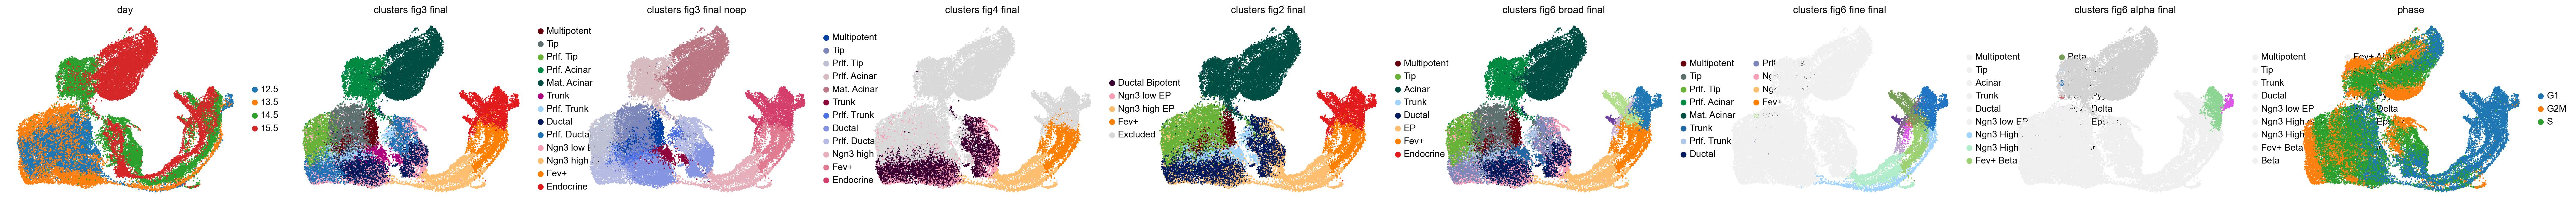

In [7]:
scv.pl.scatter(adata, color=['day','clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 
                             'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 
                             'clusters_fig6_alpha_final', 'phase'], legend_loc='right_margin')

In [8]:
def rename_cats(ref_clust):    
    from pandas import Categorical
    ref_clust[ref_clust=='Prlf. Tip']='Tip'
    ref_clust[ref_clust=='Prlf. Trunk']='Trunk'
    return Categorical(ref_clust)

adata.obs['clusters_coarse'] = rename_cats(adata.obs['clusters_fig3_final'])
adata.obs['clusters'] = rename_cats(adata.obs['clusters_fig6_broad_final'])
adata.obs['clusters_fine'] = rename_cats(adata.obs['clusters_fig6_fine_final'])

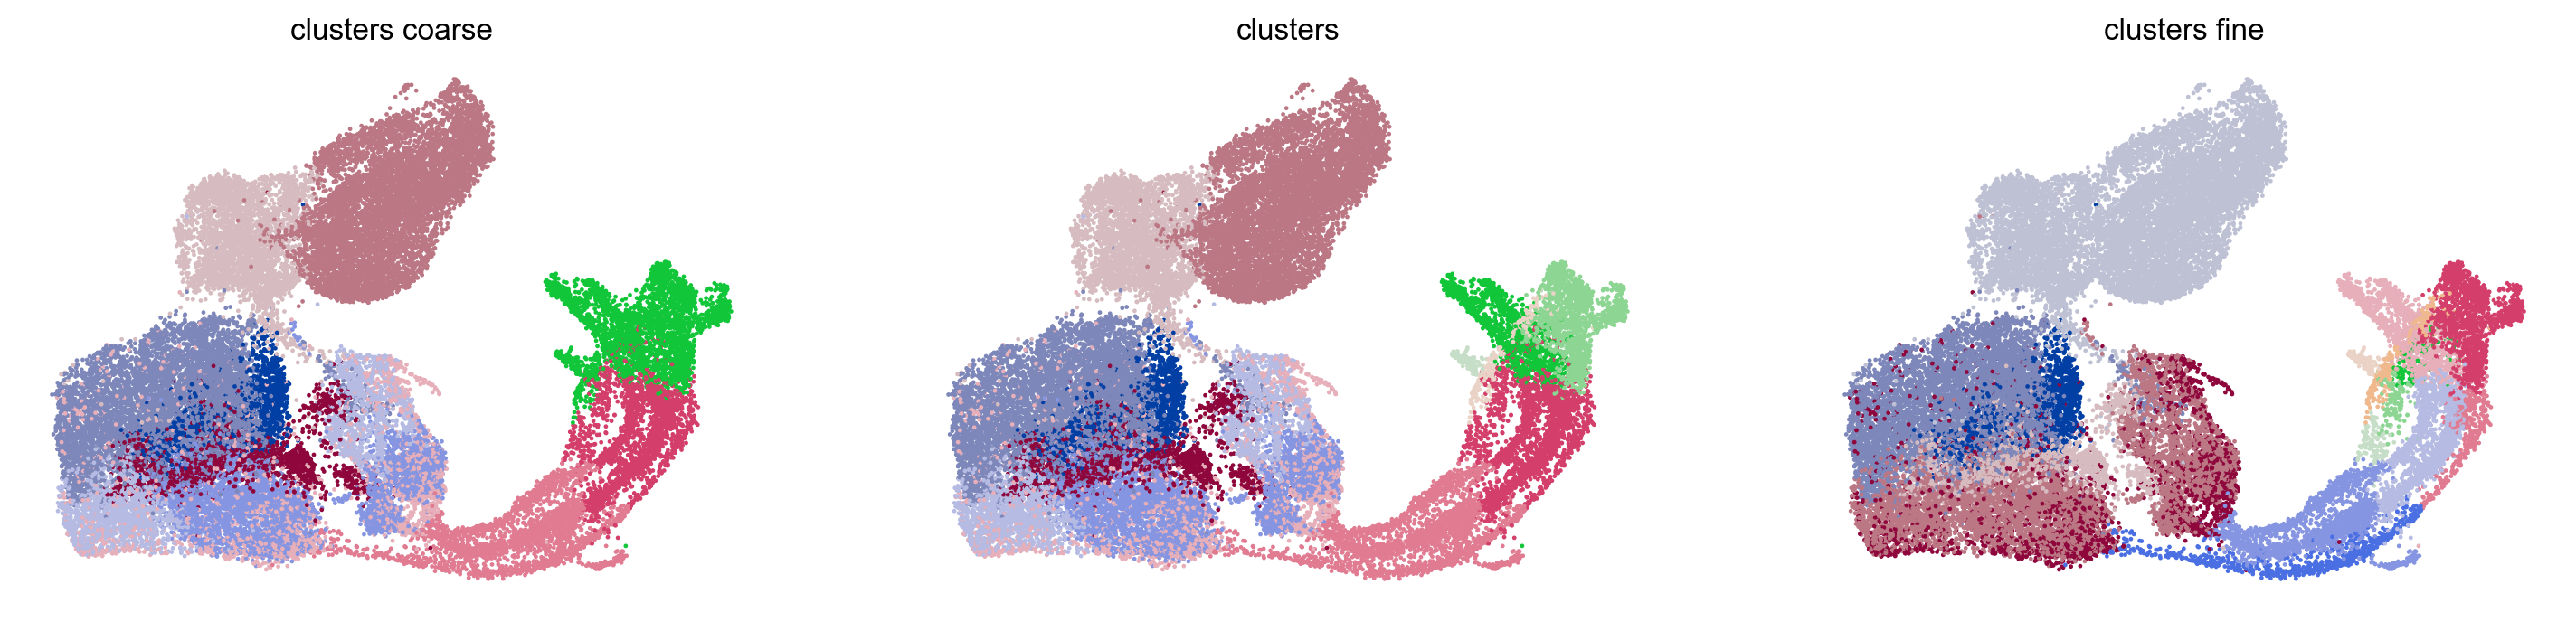

In [9]:
scv.pl.scatter(adata, color=['clusters_coarse', 'clusters', 'clusters_fine'])

## Subsetting

In [10]:
# subset to clusters connected to endocrine lineage
endocrine_lineage = ['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Endocrine']
adata_endo = adata[np.isin(adata.obs['clusters_coarse'], endocrine_lineage)].copy()

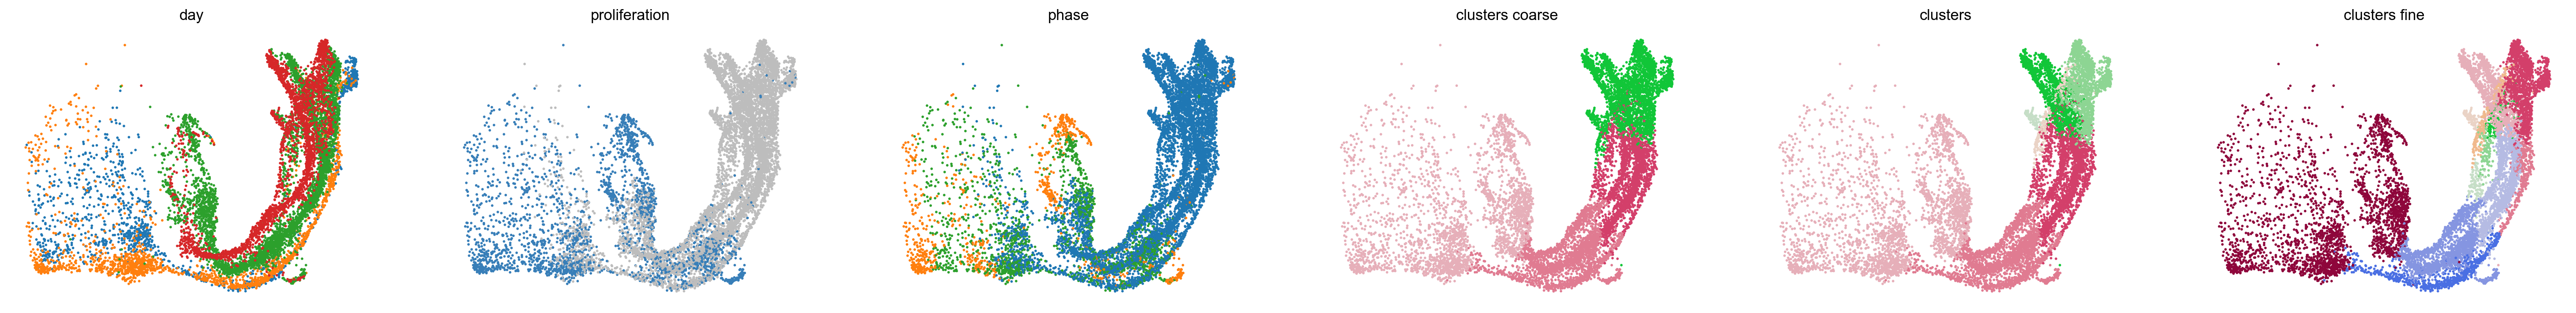

In [11]:
scv.pl.scatter(adata_endo, color=['day', 'proliferation', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine'])

Restrict to the last time point and remove cyclic cells:

In [12]:
# let's rectrict to the last two time points
mask = np.in1d(adata_endo.obs['day'], ['15.5'])
adata_endo = adata_endo[mask].copy()

# let's get rid of all proliferative cells
mask = adata_endo.obs['proliferation'] == 'Non-Cycling'
adata_endo = adata_endo[mask].copy()

In [13]:
# merge Ngng3 high late and early clusters (there is no Ngn3 high early at E15.5)

mask = adata_endo.obs['clusters_fine'] == 'Ngn3 High early'
adata_endo.obs.loc[mask, 'clusters_fine'] = 'Ngn3 High late'
adata_endo.obs['clusters_fine'].cat.remove_unused_categories(inplace=True)
adata_endo.obs['clusters_fine'].cat.rename_categories({'Ngn3 High late': 'Ngn3 high EP'}, inplace=True)

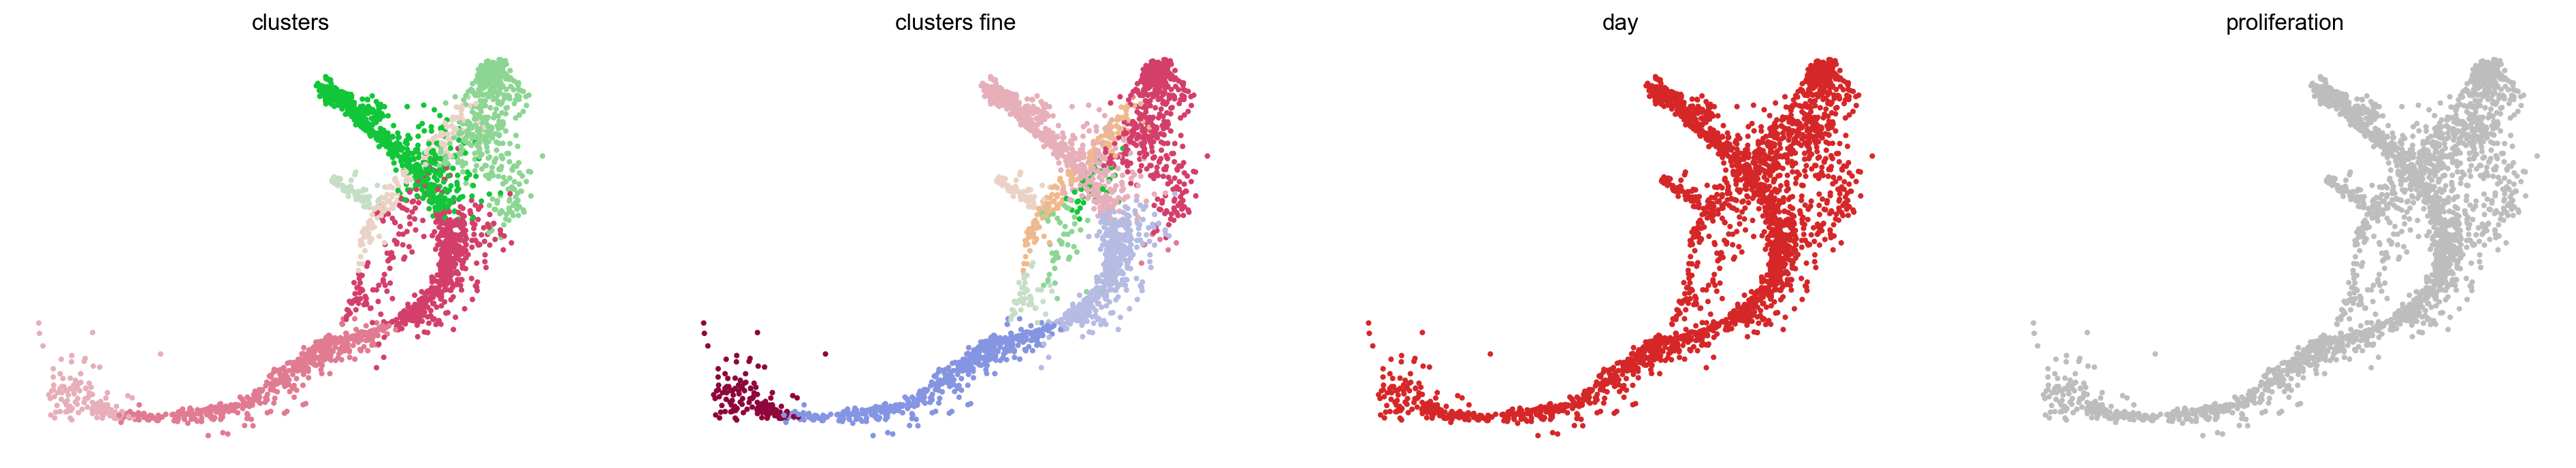

In [14]:
# make sure this worked
scv.pl.scatter(adata_endo, color=['clusters', 'clusters_fine', 'day', 'proliferation'])

## Recompute the UMAP

Comptue a new-paga based umap for this subset of the data

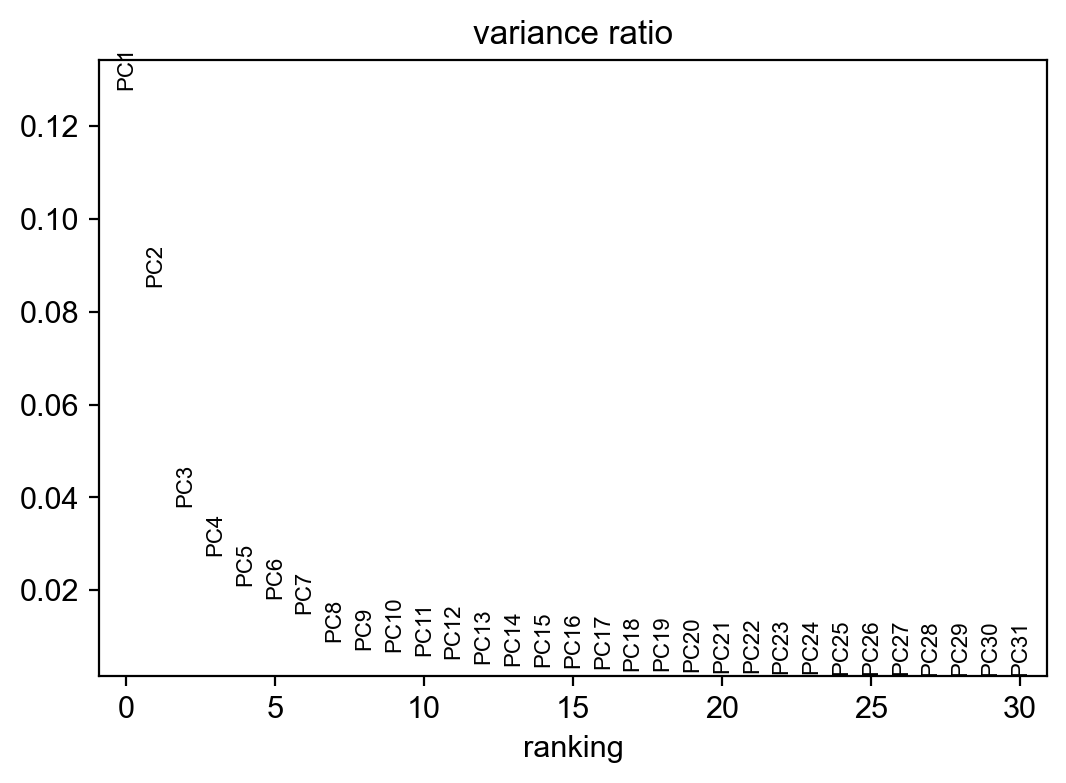

In [15]:
sc.pl.pca_variance_ratio(adata)

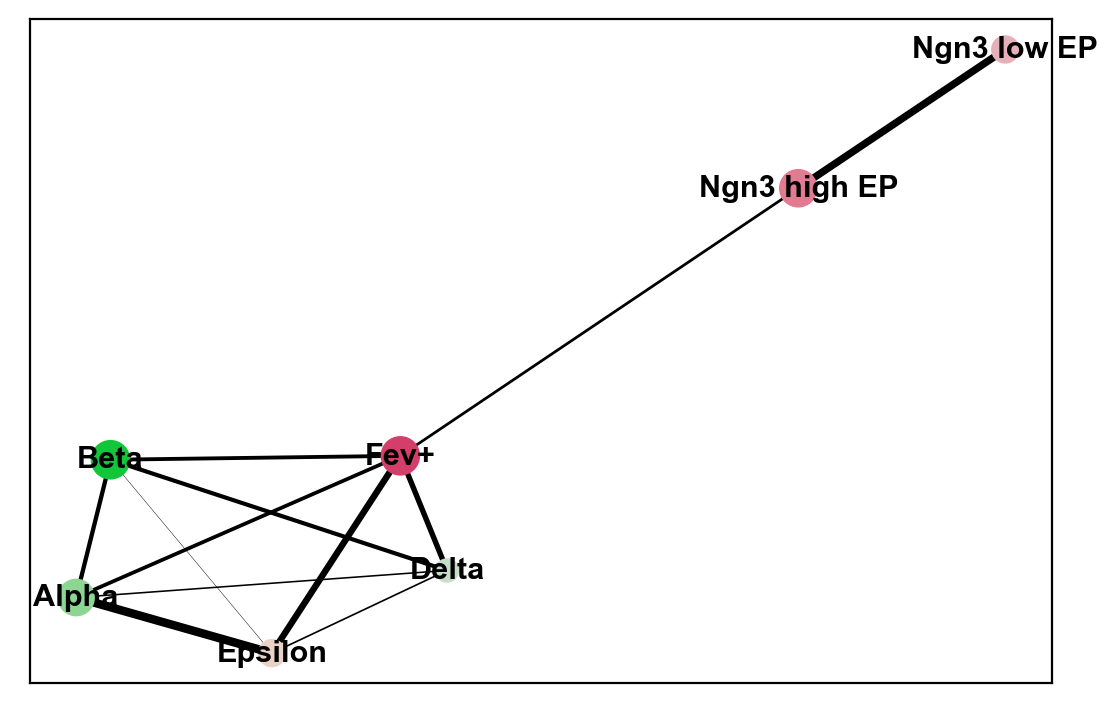

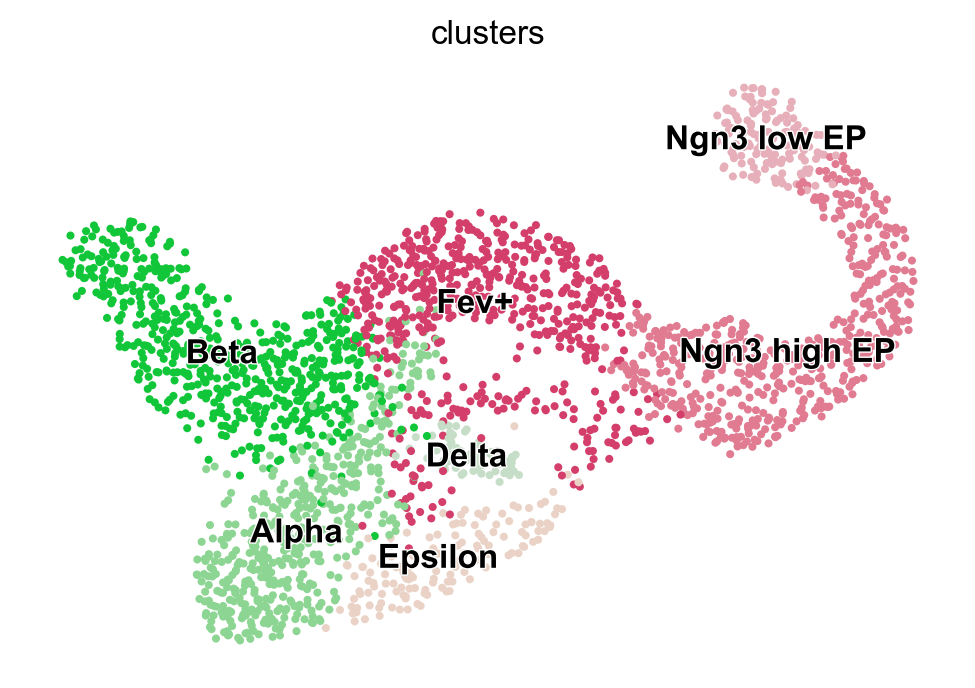

In [16]:
# re-compute the neighborhood graph
sc.pp.neighbors(adata_endo, n_neighbors=30, n_pcs=30, random_state=0)

# compute and plot PAGA, make sure to set the random state for PAGA plotting
sc.tl.paga(adata_endo, groups='clusters')
sc.pl.paga(adata_endo, random_state=0)

# compute a UMAP from PAGA initialisation
sc.tl.umap(adata_endo, init_pos='paga', min_dist=1, random_state=0)

# plot using scvelo
scv.pl.scatter(adata_endo)

In [17]:
scv.utils.cleanup(adata_endo, clean='all', keep=['day', 'clusters_coarse', 'clusters', 'clusters_fine', 'highly_variable_genes',
                                            'day_colors', 'clusters_coarse_colors', 'clusters_colors',
                                            'neighbors', 'pca', 'spliced', 'unspliced', 'G2M_score', 'S_score', 'proliferation', 'phase'])

## Subcluster Alpha and Beta states

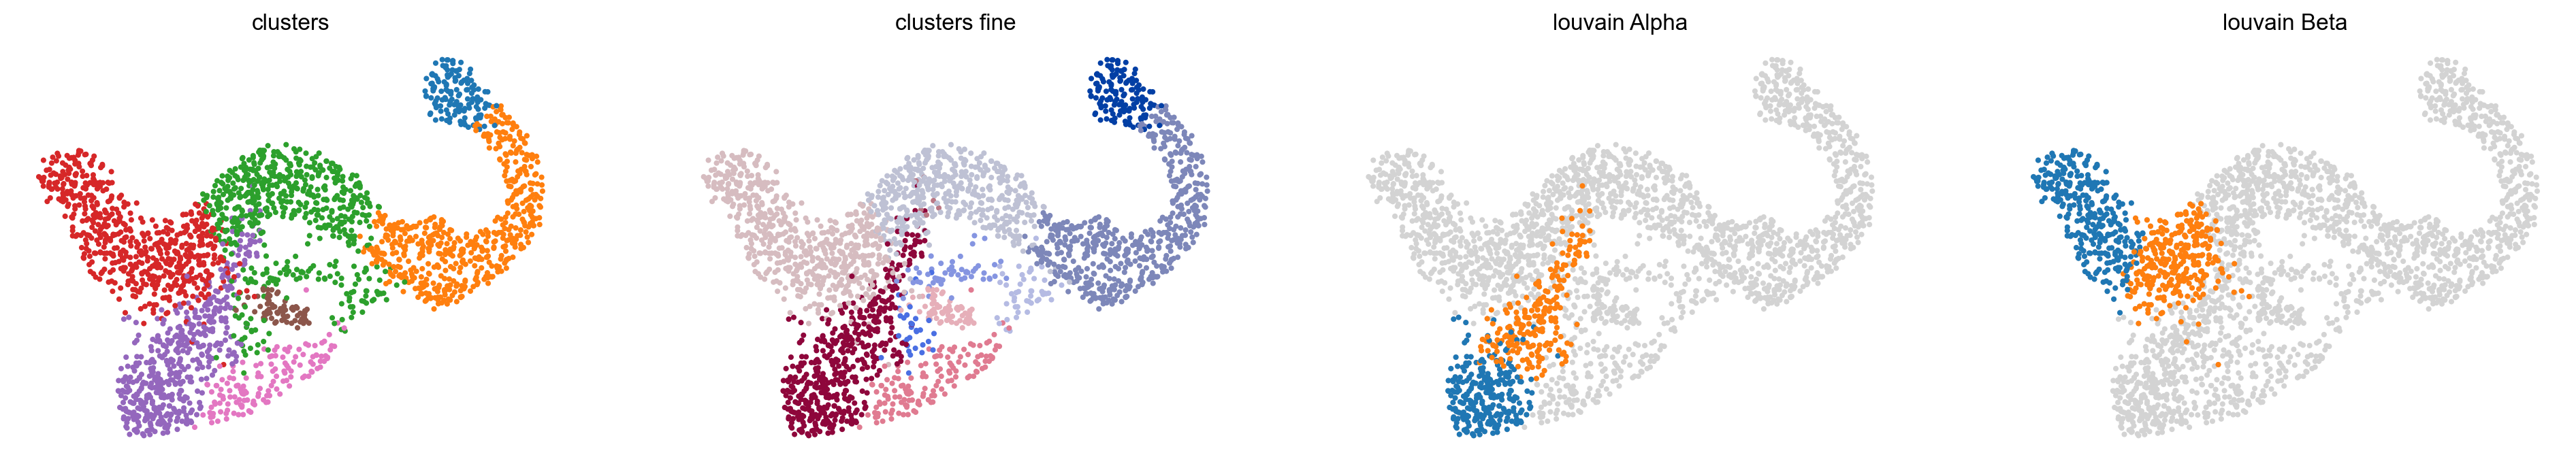

In [18]:
for cl in ['Alpha', 'Beta']:
    
    if cl == 'Alpha':
        res = 0.2
    elif cl == 'Beta':
        res = 0.2
    
    mask = adata_endo.obs['clusters'] == cl
    adata_cl = adata_endo[mask].copy()
    sc.pp.neighbors(adata_cl, random_state=0)
    sc.tl.louvain(adata_cl, resolution=res, random_state=0)
    louvain_ann = pd.Series(index=adata_endo.obs_names, dtype='category')
    louvain_ann.cat.add_categories(adata_cl.obs['louvain'].cat.categories, inplace=True)
    louvain_ann.loc[adata_cl.obs_names] = adata_cl.obs['louvain']
    adata_endo.obs[f'louvain_{cl}'] = louvain_ann 
    
scv.pl.scatter(adata_endo, color=['clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'])

We need to modify the Fev+ clusters a bit, therefore, we need some utility functions:
    

In [19]:
# from cellrank.tools._utils import _create_colors

def merge_clustering(adata, cl_key_query, cl_key_reference='clusters'):
    
    # get categories and colors
    clusters_query = adata.obs[cl_key_query].cat.categories
    clusters_reference = adata.obs[cl_key_reference].cat.categories
    colors_reference = adata.uns[f'{cl_key_reference}_colors']

    for name_query in clusters_query:
        mask = adata.obs[cl_key_query] == name_query
        if f'{cl_key_query}_{name_query}' not in adata.obs[cl_key_reference].cat.categories:
            adata.obs[cl_key_reference].cat.add_categories(f'{cl_key_query}_{name_query}', inplace=True)
        adata.obs.loc[mask, cl_key_reference] = f'{cl_key_query}_{name_query}'

    # remove unused categories
    adata.obs[cl_key_reference].cat.remove_unused_categories(inplace=True)

In [20]:
# run the function on alpha and beta, and rename the cats
merge_clustering(adata_endo, 'louvain_Alpha', 'clusters_fine')
merge_clustering(adata_endo, 'louvain_Beta', 'clusters_fine')

adata_endo.obs['clusters_fine'].cat.rename_categories({'louvain_Alpha_1': 'Pre-Alpha', 
                                             'louvain_Alpha_0': 'Alpha', 
                                             'louvain_Beta_1': 'Pre-Beta',
                                             'louvain_Beta_0': 'Beta',
                                              },
                                            inplace=True)

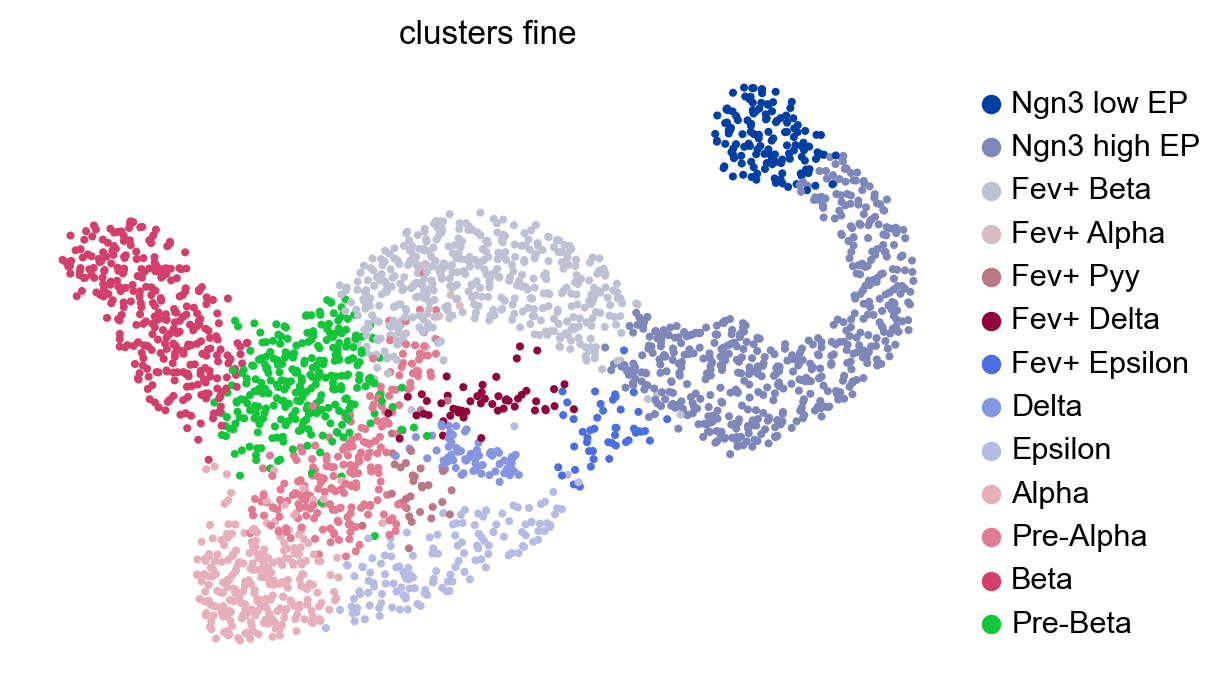

In [21]:
scv.pl.scatter(adata_endo, color='clusters_fine', legend_loc='right')

## Fix Colors

In [22]:
# annotation for `day`
adata_endo.uns['day_colors'] = np.array(['#F5793A', '#0F2080'])

In [23]:
# let's use Volker's colors on the 'clusters' level:
scv_cats = np.array(['Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta',
       'Alpha', 'Delta', 'Epsilon'])
scv_colors = np.array(['#8fbc8f', '#f4a460', '#fdbf6f', '#ff7f00', '#b2df8a', '#1f78b4',
        '#6a3d9a', '#cab2d6'])
our_cats = adata_endo.obs['clusters'].cat.categories

# subset Volker's categories to mine and apply the same subsetting to the colors
mask = np.in1d(scv_cats, our_cats)
our_cats_new = scv_cats[mask]
our_colors_new = scv_colors[mask]

adata_endo.obs['clusters'].cat.set_categories(our_cats_new, inplace=True)
adata_endo.uns['clusters_colors'] = our_colors_new

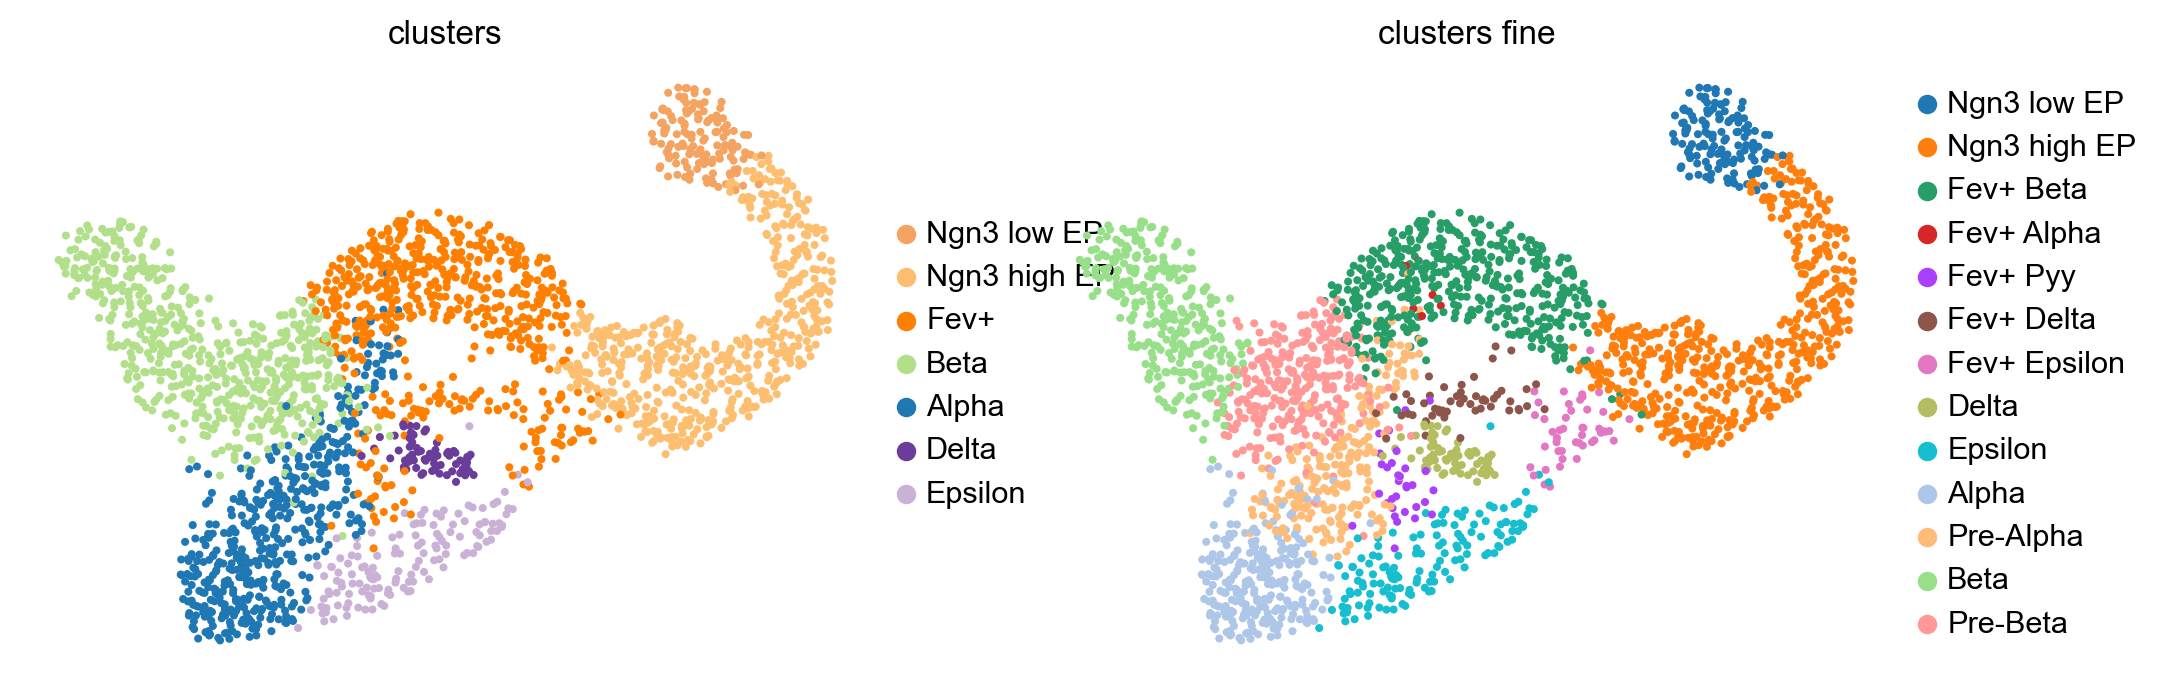

In [24]:
# for the level of `clusters_fine`, let's use a colorblind friendly palette
from matplotlib import cm, colors

# Colorblindness adjusted vega_10
# See https://github.com/theislab/scanpy/issues/387
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi

# default matplotlib 2.0 palette
# see 'category20' on https://github.com/vega/vega/wiki/Scales#scale-range-literals
vega_20 = list(map(colors.to_hex, cm.tab20.colors))

# reorderd, some removed, some added
vega_20_scanpy = [
    *vega_20[0:14:2], *vega_20[16::2],  # dark without grey
    *vega_20[1:15:2], *vega_20[17::2],  # light without grey
    '#ad494a', '#8c6d31',  # manual additions
]
vega_20_scanpy[2] = vega_10_scanpy[2]
vega_20_scanpy[4] = vega_10_scanpy[4]
vega_20_scanpy[7] = vega_10_scanpy[8]  # kakhi shifted by missing grey
default_20 = vega_20_scanpy

adata_endo.uns['clusters_fine_colors'] = default_20[:len(adata_endo.obs['clusters_fine'].cat.categories)]

scv.pl.scatter(adata_endo, legend_loc='right', color=['clusters', 'clusters_fine'])

## Save the data

In [25]:
adata_endo

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta'
    var: 'highly_variable_genes'
    uns: 'day_colors', 'neighbors', 'pca', 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors'
    obsm: 'X_umap', 'X_pca'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Plot some compositions

In [26]:
import cellrank as cr

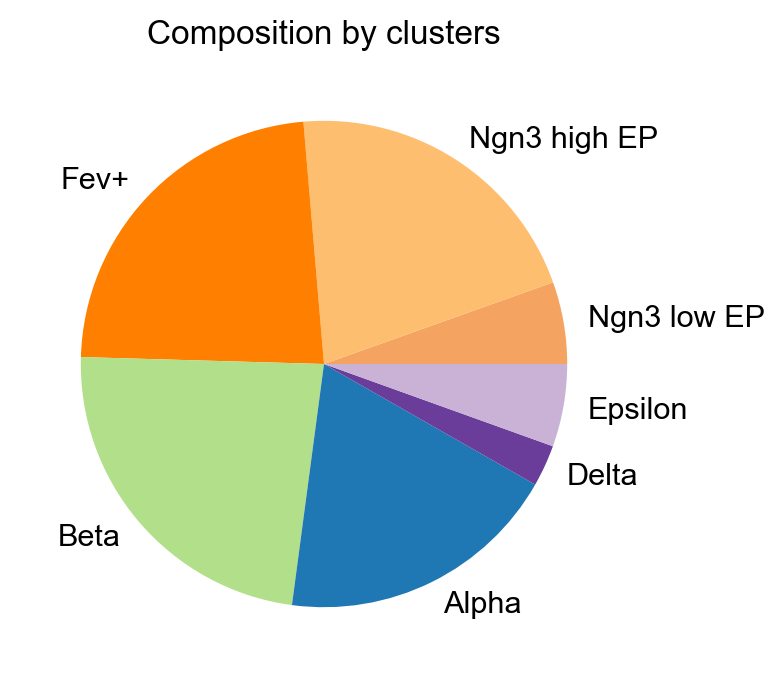

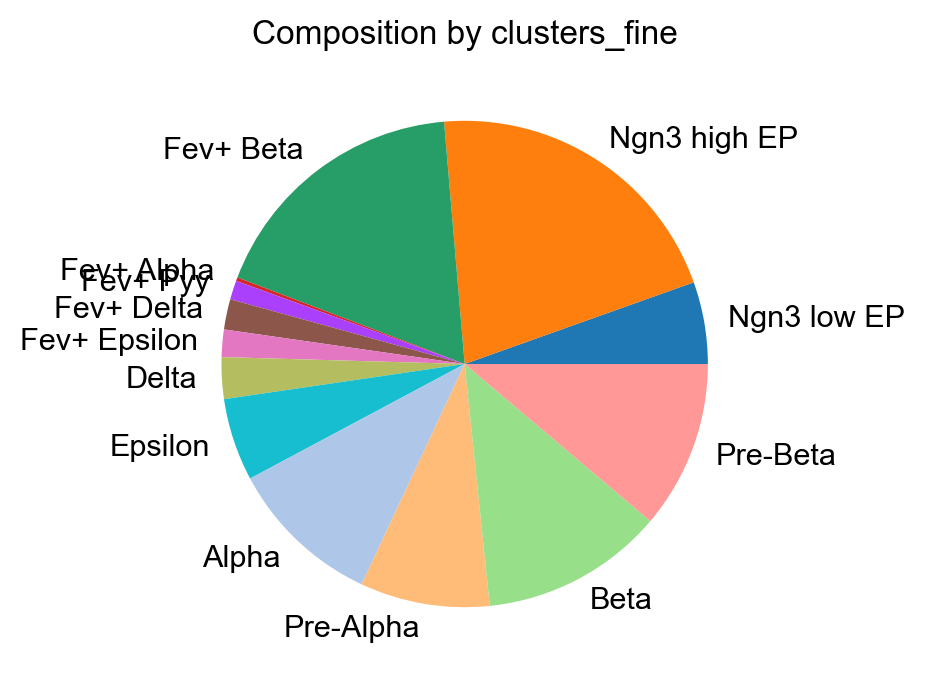

In [27]:
cr.pl.composition(adata_endo, 'clusters')
cr.pl.composition(adata_endo, 'clusters_fine')

In [28]:
adata_endo.write('../../../data/pancreas/180620_ml_endocrinogenesis_E15.5.h5ad', compression='gzip')